In [8]:
import torch
import viplanner_wrapper
import hydra
from omegaconf import DictConfig
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from typing import Tuple
from PIL import Image

import open3d as o3d
import numpy as np

from viplanner.viplanner.traj_cost_opt.traj_cost import TrajCost
import utils

import cv2
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
def loss(
    waypoints: torch.Tensor,
    fear: torch.Tensor,
    traj_cost: TrajCost,
    odom: torch.Tensor,
    goal: torch.Tensor,
    step: float = 0.1,
    dataset: str = "train",
) -> Tuple[torch.Tensor, torch.Tensor]:
    print(f"traj cost {traj_cost}")
    loss = traj_cost.CostofTraj(
        waypoints,
        odom,
        goal,
        fear,
        0,
        ahead_dist=2.5,
        dataset=dataset,
    )

    return loss, waypoints
    
def visualize_path():
    # Access configuration parameters
    model_path = "/scratch/minh/school/282_project/PlanningInterpretability/models"
    data_path = "/scratch/minh/school/282_project/carla"
    camera_cfg_path = "/scratch/minh/school/282_project/carla/camera_extrinsic.txt"
    device = "cuda:6"

    img_num = 8

    viplanner = viplanner_wrapper.VIPlannerAlgo(model_dir=model_path, device=device, eval=False)

    # Load and process images from training data. Need to reshape to add batch dimension in front
    depth_image, sem_image = viplanner_wrapper.preprocess_training_images(data_path, img_num, device)
    cam_pos, cam_quat = utils.load_camera_extrinsics(camera_cfg_path, img_num, device=device)

    # setup goal, also needs to have batch dimension in front
    goal = cam_pos + torch.tensor([0.0, 50.0, 1.0])
    goals = torch.tensor(goal, device=device).repeat(1, 1)
    # goals = viplanner_wrapper.transform_goal(camera_cfg_path, goals, img_num, device)
    print("trasformed goals", goals)

    depth_image = viplanner.input_transformer(depth_image)

    # forward/inference
    keypoints, paths, fear = viplanner.plan_dual(depth_image, sem_image, goals, no_grad=True)

    return keypoints, paths, fear, depth_image, sem_image, goals

NameError: name 'torch' is not defined

In [21]:
keypoints, paths, fear, depth_image, sem_image, goals = visualize_path()

Model loaded using sem: True, rgb: False, knodes: 5, in_channel: 16
trasformed goals tensor([[ 0., 50.,  1.]], device='cuda:6')
autoencoder depth shape torch.Size([1, 1, 360, 640])
autoencoder sem shape torch.Size([1, 3, 360, 640])
encoded depth shape torch.Size([1, 512, 12, 20])
encoded sem shape torch.Size([1, 512, 12, 20])


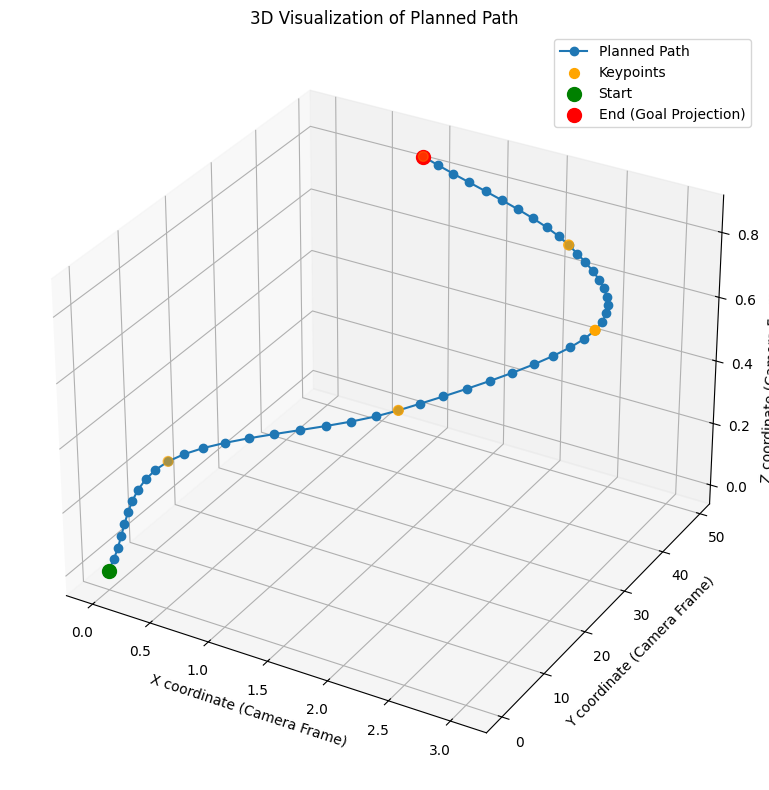

end position is  tensor([ 0.8979, 49.0657,  0.8444], device='cuda:6')


In [19]:
# Extract path coordinates (assuming batch size is 1)
path_points_3d = paths[0].detach().cpu().numpy()
x_coords = path_points_3d[:, 0]
y_coords = path_points_3d[:, 1]
z_coords = path_points_3d[:, 2]

# Create a 3D plot with interactive settings
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the path
path_line = ax.plot(x_coords, y_coords, z_coords, marker='o', linestyle='-', label='Planned Path')[0]

# plot the keypoints
keypoints_3d = keypoints[0].detach().cpu().numpy()
keypoints_x = keypoints_3d[:, 0]
keypoints_y = keypoints_3d[:, 1]
keypoints_z = keypoints_3d[:, 2]
keypoints_line = ax.scatter(keypoints_x, keypoints_y, keypoints_z, color='orange', s=50, label='Keypoints')

# Mark start and end points
start_point = ax.scatter(x_coords[0], y_coords[0], z_coords[0], color='green', s=100, label='Start')
end_point = ax.scatter(x_coords[-1], y_coords[-1], z_coords[-1], color='red', s=100, label='End (Goal Projection)')

# Add labels and title
ax.set_xlabel('X coordinate (Camera Frame)')
ax.set_ylabel('Y coordinate (Camera Frame)')
ax.set_zlabel('Z coordinate (Camera Frame - Forward)')
ax.set_title('3D Visualization of Planned Path')
ax.legend()

# Tighten layout
plt.tight_layout()

plt.show()
print("end position is ", paths[0][-1])

Image dimensions: (720, 1280, 3)
Z value stats: min=0.00, max=0.85, mean=0.55
Number of points with z > 0.1: 47
Point 4: 3D=(-0.00, 3.68, 0.10) → 2D=(416, 15698)
  - Outside image bounds
Point 5: 3D=(-0.01, 4.60, 0.13) → 2D=(404, 15685)
  - Outside image bounds
Point 6: 3D=(-0.00, 5.52, 0.15) → 2D=(416, 15698)
  - Outside image bounds
Point 7: 3D=(0.01, 6.44, 0.18) → 2D=(453, 15736)
  - Outside image bounds
Point 8: 3D=(0.04, 7.37, 0.20) → 2D=(513, 15801)
  - Outside image bounds
Point 9: 3D=(0.09, 8.31, 0.23) → 2D=(599, 15893)
  - Outside image bounds
Points inside image bounds: 0 of first 10 points
Direct projection: 0 points in image
Trying scaled projection with factor 0.1
Scaled projection: 2 points in image


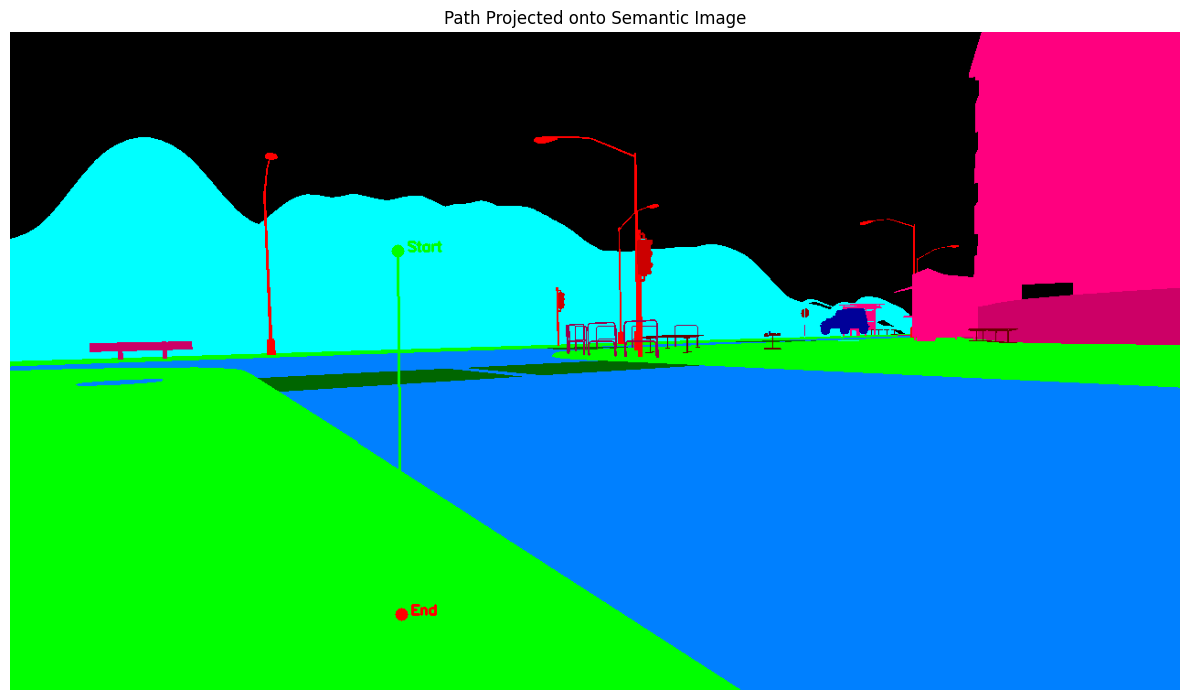

Saved visualization to path_on_semantic.png


In [24]:
def project_path_to_image(paths, sem_image):
    """Project 3D path onto the image plane and overlay it on the semantic image"""
    # Camera intrinsics from the provided data
    fx = 430.69473  # Focal length x
    fy = 430.69476  # Focal length y
    cx = 424.0      # Principal point x
    cy = 240.0      # Principal point y
    
    # Get path points
    path_points = paths[0].detach().cpu().numpy()
    
    # Convert semantic image tensor to a numpy array for visualization
    if len(sem_image.shape) == 4:
        sem_np = sem_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    else:
        sem_np = sem_image.permute(1, 2, 0).cpu().numpy()
        
    # Normalize image if needed
    if sem_np.max() <= 1.0:
        sem_np = sem_np * 255
    sem_np = sem_np.astype(np.uint8)
    
    # Create a copy of the image to draw on
    vis_img = sem_np.copy()
    if vis_img.shape[2] == 1:
        vis_img = cv2.cvtColor(vis_img, cv2.COLOR_GRAY2BGR)
    
    # Print image dimensions
    print(f"Image dimensions: {vis_img.shape}")
    
    # Analyze path points
    z_vals = path_points[:, 2]
    print(f"Z value stats: min={z_vals.min():.2f}, max={z_vals.max():.2f}, mean={z_vals.mean():.2f}")
    print(f"Number of points with z > 0.1: {np.sum(z_vals > 0.1)}")
    
    # APPROACH 1: Try direct projection with clearer debug info
    points_2d_direct = []
    inside_count = 0
    for i, point in enumerate(path_points):
        x, y, z = point[0], point[1], point[2]
        
        # Skip points behind the camera or too close to camera
        if z <= 0.1:
            continue
        
        # Apply perspective projection
        u = int(fx * (x / z) + cx)
        v = int(fy * (y / z) + cy)
        
        # Debug info for first few points
        if i < 10:
            print(f"Point {i}: 3D=({x:.2f}, {y:.2f}, {z:.2f}) → 2D=({u}, {v})")
            if 0 <= u < vis_img.shape[1] and 0 <= v < vis_img.shape[0]:
                print("  - Inside image bounds")
                inside_count += 1
            else:
                print("  - Outside image bounds")
        
        # Check if point is within image bounds
        if 0 <= u < vis_img.shape[1] and 0 <= v < vis_img.shape[0]:
            points_2d_direct.append((u, v))
    
    print(f"Points inside image bounds: {inside_count} of first 10 points")
    print(f"Direct projection: {len(points_2d_direct)} points in image")
    
    # APPROACH 2: Add a scaling factor to bring points into view if needed
    points_2d_scaled = []
    scale_factor = 0.1  # Try different values: 0.01, 0.1, 0.5, etc.
    print(f"Trying scaled projection with factor {scale_factor}")
    
    for point in path_points:
        x, y, z = point[0] * scale_factor, point[1] * scale_factor, max(0.1, point[2] * scale_factor)
        
        # Apply perspective projection with scaled coordinates
        u = int(fx * (x / z) + cx)
        v = int(fy * (y / z) + cy)
        
        # Check if point is within image bounds
        if 0 <= u < vis_img.shape[1] and 0 <= v < vis_img.shape[0]:
            points_2d_scaled.append((u, v))
    
    print(f"Scaled projection: {len(points_2d_scaled)} points in image")
    
    # Choose the best projection (whichever gave more points)
    points_2d = points_2d_direct if len(points_2d_direct) > len(points_2d_scaled) else points_2d_scaled
    
    # If we still have no points, use normalization approach as a fallback
    if len(points_2d) == 0:
        print("No points projected successfully. Using fallback normalization approach...")
        
        # Extract x and y coordinates
        xs = path_points[:, 0]
        ys = path_points[:, 1]
        
        # Center of the image
        img_center_x = vis_img.shape[1] // 2
        img_center_y = vis_img.shape[0] // 2
        
        # Scale factor - use 1/4 of the image width/height
        scale_x = vis_img.shape[1] // 4 / max(abs(xs.max()), abs(xs.min()))
        scale_y = vis_img.shape[0] // 4 / max(abs(ys.max()), abs(ys.min()))
        scale = min(scale_x, scale_y)
        
        # Project points using simple scaling
        for x, y in zip(xs, ys):
            u = int(img_center_x + x * scale)
            v = int(img_center_y + y * scale)
            if 0 <= u < vis_img.shape[1] and 0 <= v < vis_img.shape[0]:
                points_2d.append((u, v))
        
        print(f"Fallback approach: {len(points_2d)} points in image")
    
    # Draw path as line with gradient color
    if len(points_2d) > 1:
        for i in range(len(points_2d) - 1):
            # Create color gradient from green (start) to red (end)
            ratio = i / max(1, len(points_2d) - 2)
            b = 0
            g = int(255 * (1 - ratio))
            r = int(255 * ratio)
            cv2.line(vis_img, points_2d[i], points_2d[i+1], (b, g, r), 2)
    
        # Draw waypoints
        for i, point in enumerate(points_2d):
            if i == 0:  # Start point
                cv2.circle(vis_img, point, 7, (0, 255, 0), -1)  # Green
                cv2.putText(vis_img, "Start", (point[0]+10, point[1]), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            elif i == len(points_2d) - 1:  # End point
                cv2.circle(vis_img, point, 7, (0, 0, 255), -1)  # Red
                cv2.putText(vis_img, "End", (point[0]+10, point[1]), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                # Size of intermediate points decreases along the path
                size = max(2, int(5 * (1 - ratio)))
                cv2.circle(vis_img, point, size, (0, 165, 255), -1)  # Orange
    
        # Display the result
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title('Path Projected onto Semantic Image')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Save the visualization
        cv2.imwrite('path_on_semantic.png', vis_img)
        print("Saved visualization to path_on_semantic.png")
    else:
        print("ERROR: Not enough points to draw path after projection")
    
    return vis_img

# Call the updated function
overlay_img = project_path_to_image(paths, sem_image)